<a href="https://colab.research.google.com/github/n1az/Bayes-IDA/blob/main/exercise2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Bayesian inference and Data assimilation
## Exercise 2

### Contributors : `Md. Niaz Morshed`, `Jayed Akbar Sumon`,` Mohammad Hasan`,`Shahriar Shohid Choudhury`

*Group: `Duckies`*

## **Problem 1.1**
Here we are implementing the Lorenz-63 model using Euler's method and storing the resulting reference trajectory in time intervals of Δt_out = 0.05 in a file named 'lorenz_data.csv' for later use. The system state is not stored at every single timestep but is overwritten on each timestep and a copy of the vector is taken when it needs to be stored. The resulting data set is stored in a matrix of size 3 × 4001.




In [326]:
from matplotlib import colors
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import matplotlib.pyplot as plt

# Set the initial conditions and time step
x0, y0, z0 = -0.587, -0.563, 16.870
dt = 0.001
num_steps = int(200/dt)
a = 1/np.sqrt(dt)
t_out = 0.05
cycle = 4001
z_0 = np.array([-0.587, -0.563, 16.870])

# Initialize the forcing term
gn = np.array([a * (1/np.sqrt(2) - 0.5), 
                a * (1/np.sqrt(3) - 0.5), 
                a * (1/np.sqrt(5) - 0.5)])


### *Creating the `lorenz` function to calculate $f(z)$ with given parameter values [using 1.4]*

In [327]:
def lorenz(xyz, *, s=10, r=28, b=8/3):
    """
    Parameters
    ----------
    xyz : array-like, shape (3,)
       Point of interest in three-dimensional space.
    s, r, b : float
       Parameters defining the Lorenz attractor.

    Returns
    -------
    xyz_dot : array, shape (3,)
       Values of the Lorenz attractor's partial derivatives at *xyz*.
    """
    x, y, z = xyz 
    x_dot = s*(y - x) 
    y_dot = x*(r-z) - y 
    z_dot = x*y - b*z 
    return np.array([x_dot, y_dot, z_dot])




### *Calculating the nonautonomous forcing term `g` to update `gn` using 1.28*

In [328]:
# Define the non-autonomous forcing term g
def g(gn):
    # Define the forcing term as a recursive function of gn
    gn_1 = []
    for g in gn:
        if -a/2 <= g < 0:
            val = 1.99999 * g + a/2
        else:
            val = -1.99999 * g + a/2
        gn_1.append(val)
    
    return np.array(gn_1)



### *calculate $f(z)$ with given parameter values [using 1.2]*

In [329]:
def calculate_z():
    data = np.zeros([cycle, 3])
    z = z_0
    gx = gn
    
    index = 0
    step = int(t_out/dt)
    
    '''store only the observed states'''
    for i in range(num_steps):
        if i % step == 0: 
            data[index:] = z
            index += 1
            
        z = z + dt * (lorenz(z) + gx)
        gx = g(gx)
    
    return data.T

In [330]:
refs = calculate_z()
print("Reference Trajectory:\n", refs)
print("\nShape:", refs.shape)

#store the resulting reference trajectory in the csv file for later use
np.savetxt('lorenz_data.csv', refs, delimiter=',')

Reference Trajectory:
 [[-0.587      -0.62295029 -0.76136603 ... 10.05719656  8.12255936
   8.12255936]
 [-0.563      -0.87533738 -1.23681802 ...  6.32831178  4.23563173
   4.23563173]
 [16.87       14.78195993 12.92924593 ... 32.81354075 30.94937366
  30.94937366]]

Shape: (3, 4001)


### *Plotting the `Lorenz Attractor` from the calculation*

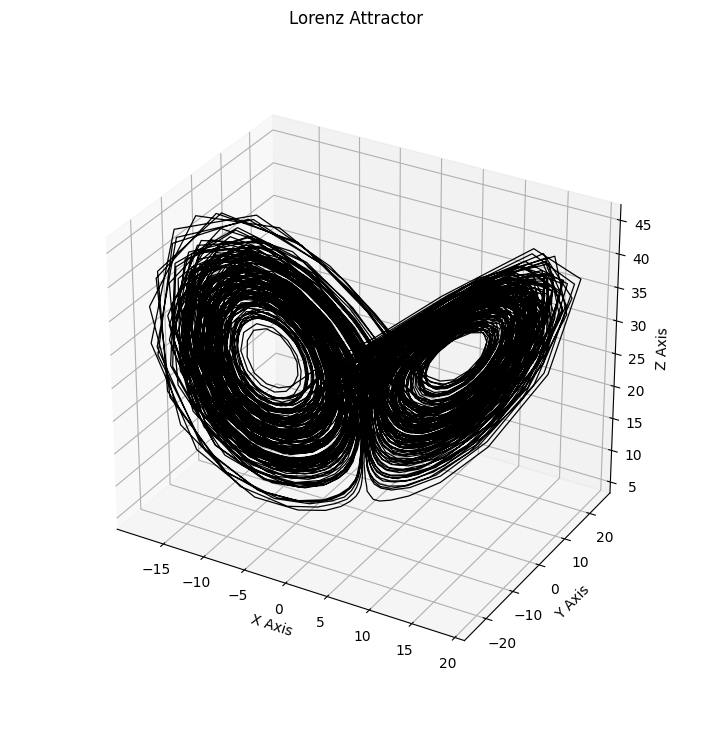

In [331]:
# Plot
ax = plt.figure(figsize=(9,9)).add_subplot(projection='3d')
ax.get_proj = lambda: np.dot(Axes3D.get_proj(ax), np.diag([0.9, 0.7, 1, 1]))
ax.plot(*refs, lw=0.9, c='k')
ax.set_xlabel("X Axis")
ax.set_ylabel("Y Axis")
ax.set_zlabel("Z Axis")
ax.set_title("Lorenz Attractor")
plt.show()

In [332]:
refs[0][3:7]

array([-1.10229066, -1.60115531, -2.43963837, -3.76403066])

## **Problem 1.2**

In [333]:
# initializing starting values
datax = np.genfromtxt('lorenz_data.csv', delimiter=',')
a = 4
xi_0 = a*(1/np.sqrt(2)-0.5)
N = datax.shape[1] * 20
N_xi = datax.shape[1] * 20

### *linear forward operator [Example 1.2 in page 5]*


In [334]:
def get_x_ref():
    return datax[0][1:]

### *modified tent map to model measurement errors [using 1.28]*

In [335]:
def tent_map():
    index = 0
    xi = xi_0
    data_xi = np.zeros(N_xi)
    
    #store every tenth iterate in the array equation 1.10
    for i in range(N):
        if i % 10 == 0:
            data_xi[index] = xi
            index = index + 1
            
        #Using equation 1.28
        if -a / 2 <= xi < 0:
            xi = 1.99999 * xi + a / 2
        else:
            xi = -1.99999 * xi + a / 2
        
    #average of first 20 errors [Example 1.2]
    data_xi = data_xi.reshape(datax.shape[1], 20)
    data_xi = np.mean(data_xi, axis=1)
    return data_xi[1:]

### *modified tent map to model measurement errors [using 1.9]*

In [336]:
def tent_map_1():
    index = 0
    xi = xi_0
    data_xi = np.zeros(N_xi)
    
    #store every tenth iterate in the array equation 1.10
    for i in range(N):
        if i % 10 == 0:
            data_xi[index] = xi
            index = index + 1
            
        #Using equation 1.9
        if -a / 2 <= xi < 0:
            xi = 2 * xi + a / 2
        else:
            xi = -2 * xi + a / 2
        
    #average of first 20 errors [Example 1.2]
    data_xi = data_xi.reshape(datax.shape[1], 20)
    data_xi = np.mean(data_xi, axis=1)
    return data_xi[1:]

### *Observation `x_obs` at time `delta_t_out` = 0.05 [Example 1.2]*

In [337]:
#x_obs = x_ref + error for recursion 1.28

def get_x_obs():
    error = tent_map()
    return  get_x_ref() + error, error

In [338]:
#x_obs = x_ref + error for recursion 1.9

def get_x_obs_1():
    error = tent_map_1()
    return  get_x_ref() + error, error

### *Calculating observations using recursion from 1.28*

In [339]:
x_ref = get_x_ref()
x_obs, errors = get_x_obs()

print("The values of x_ref:", x_ref, "\n")
print("The values of x_obs:", x_obs, "\n")
print("The values of Errors:", errors, "\n")
print("Shape of x_obs:", x_obs.shape)

# Store the numerically generated observation values x_obs
np.savetxt('x_obs_1.csv', x_obs, delimiter=',')

The values of x_ref: [-0.62295029 -0.76136603 -1.10229066 ... 10.05719656  8.12255936
  8.12255936] 

The values of x_obs: [-0.22090305 -0.68479925 -1.24329242 ... 10.05719656  8.12255936
  8.12255936] 

The values of Errors: [ 0.40204724  0.07656678 -0.14100175 ...  0.          0.
  0.        ] 

Shape of x_obs: (4000,)


### *Plotting the observed values and measurement errors for recursion 1.28*

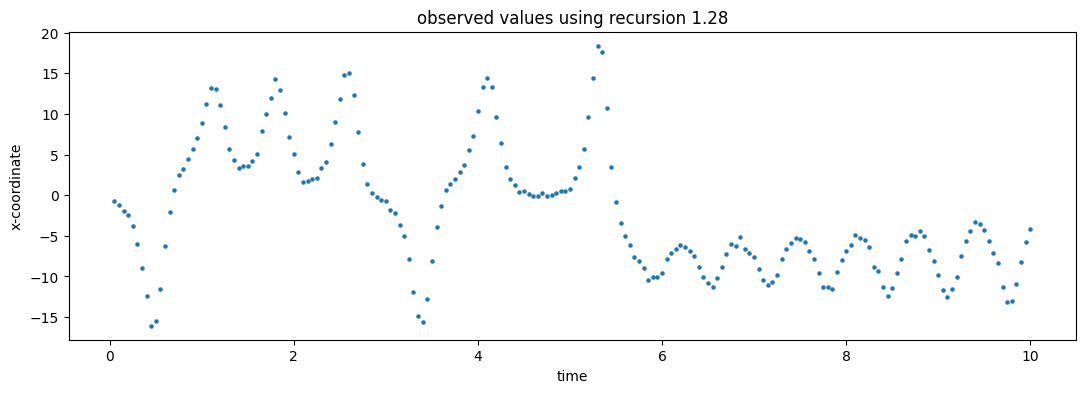

In [340]:
time = np.linspace(0, 200, 4001)
fig = plt.figure(figsize=(13,4))

plt.scatter(time[1:201], x_obs[1:201], s=5)
plt.title("observed values using recursion 1.28")
plt.ylabel("x-coordinate")
plt.xlabel("time")


plt.show()

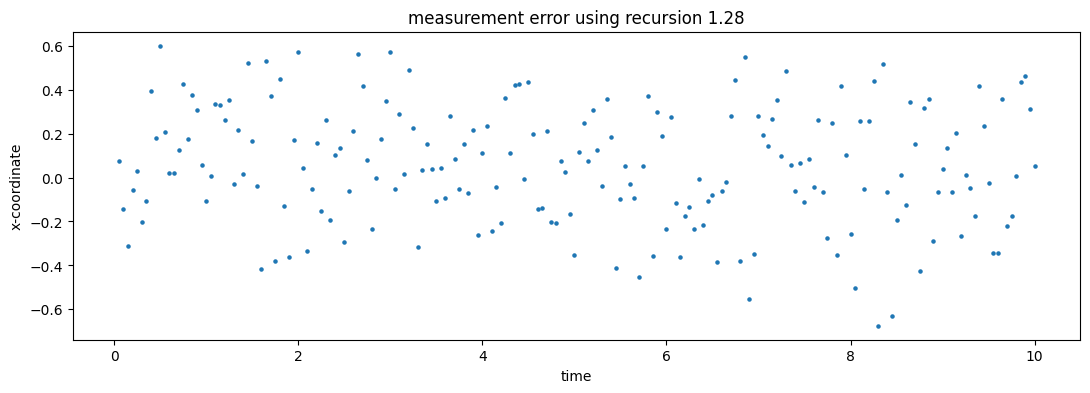

In [341]:
time = np.linspace(0, 200, 4001)
fig = plt.figure(figsize=(13, 4))

plt.scatter(time[1:201], errors[1:201], s=5)
plt.title("measurement error using recursion 1.28")
plt.ylabel("x-coordinate")
plt.xlabel("time")

plt.show()

### *Calculating observations using recursion from 1.9*

In [342]:
x_obs_1, errors_1 = get_x_obs_1()

print("The values of x_obs:", x_obs_1, "\n")
print("The values of Errors:", errors_1, "\n")
print("Shape of x_obs:", x_obs_1.shape)

# Store the numerically generated observation values x_obs
np.savetxt('x_obs_2.csv', x_obs, delimiter=',')

The values of x_obs: [-2.62295029 -2.76136603 -3.10229066 ... 10.05719656  8.12255936
  8.12255936] 

The values of Errors: [-2. -2. -2. ...  0.  0.  0.] 

Shape of x_obs: (4000,)


### *Plotting the observed values and measurement errors for recursion 1.9*

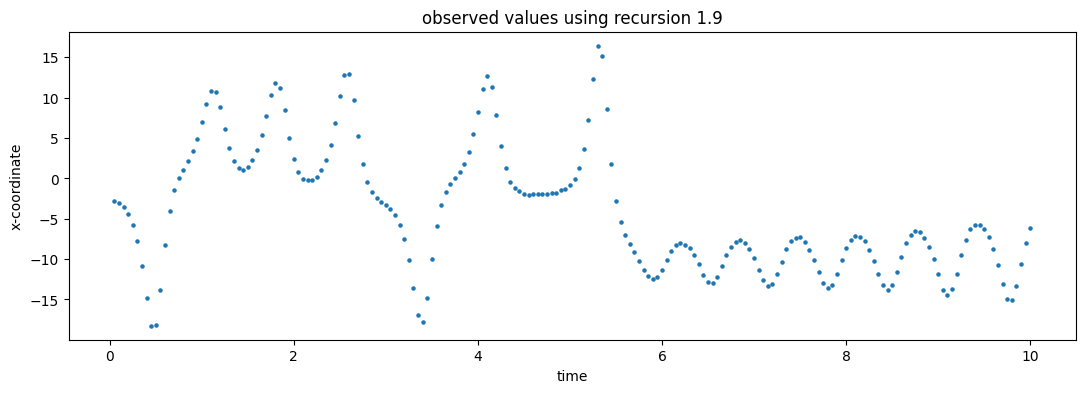

In [343]:
time = np.linspace(0, 200, 4001)
fig = plt.figure(figsize=(13,4))

plt.scatter(time[1:201], x_obs_1[1:201], s=5)
plt.title("observed values using recursion 1.9")
plt.ylabel("x-coordinate")
plt.xlabel("time")


plt.show()

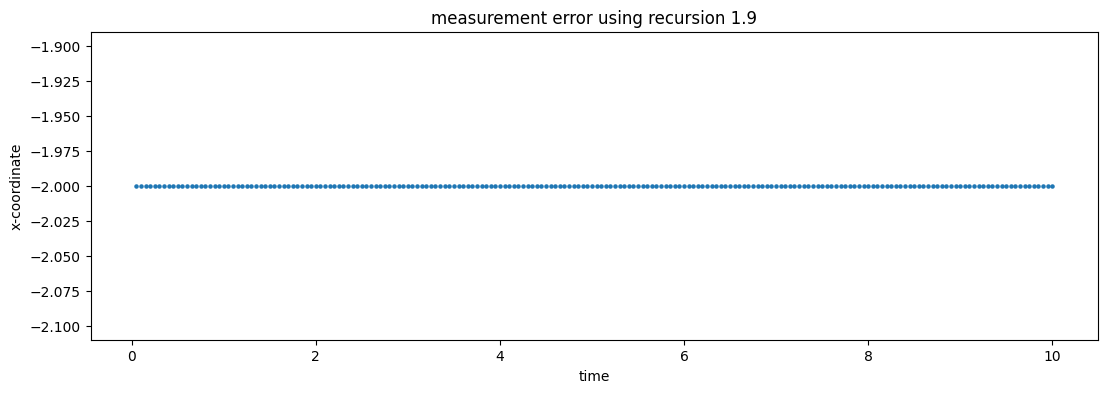

In [344]:
time = np.linspace(0, 200, 4001)
fig = plt.figure(figsize=(13, 4))

plt.scatter(time[1:201], errors_1[1:201], s=5)
plt.title("measurement error using recursion 1.9")
plt.ylabel("x-coordinate")
plt.xlabel("time")

plt.show()

### *Plotting the difference between observed values and measurement errors for recursion 1.28 and 1.9*

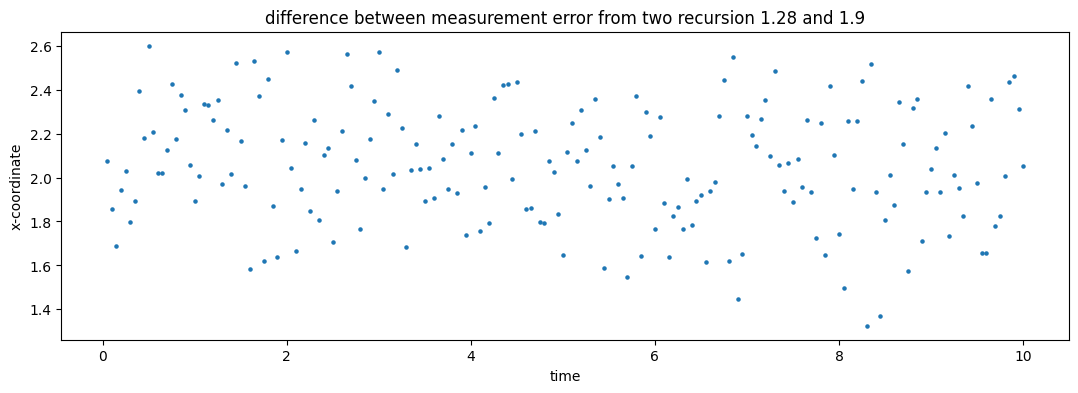

In [345]:
time = np.linspace(0, 200, 4001)
fig = plt.figure(figsize=(13, 4))

plt.scatter(time[1:201], errors[1:201]- errors_1[1:201], s=5)
plt.title("difference between measurement error from two recursion 1.28 and 1.9")
plt.ylabel("x-coordinate")
plt.xlabel("time")

plt.show()

## **Problem 1.3**

### *Loading observations from problem 1.2*

In [346]:
y_obs = np.genfromtxt('x_obs_1.csv', delimiter=',')
N = len(y_obs)

### *Creating predictor `Δtout` = 0.05 using euqtion 1.12*

In [347]:
#When Δtout = 0.05 we calculate the y_predict(t_k) using euqtion 1.12

def y_predict_05(y_obs_k, y_obs_k_1):
    return 2 * y_obs_k - y_obs_k_1
 
    
#Calculate y_predict(t_[k+1] when Δtout = 0.05)

def calc_y_predict_05():
    y_pred = np.zeros(N)
    #skip the first 2 values according to the equation
    y_pred[:2] = np.NaN 
        
    for i in range(2, N):
        y_pred[i] = y_predict_05(y_obs[i-1], y_obs[i-2])
    
    return y_pred
 

In [348]:
# predicting y
y_predict_05 = calc_y_predict_05()

print("The values of Y predict when Δtout = 0.05: ", y_predict_05)

The values of Y predict when Δtout = 0.05:  [        nan         nan -1.14869546 ... 11.18690915  8.61400892
  6.18792217]


### *Calculating Time averaged RMSE when `Δtout` = 0.05*

In [349]:
#Calculating Root mean square error (RMSE) when Δtout = 0.05 using equation 1.13
rmse_05 = np.sqrt(1/(N-2) * np.nansum((y_obs - y_predict_05)**2))
print("Time averaged RMSE when Δtout = 0.05 is", rmse_05)

Time averaged RMSE when Δtout = 0.05 is 1.2027560635775536


### *PLotting observed and predicted values when `Δtout` = 0.05*

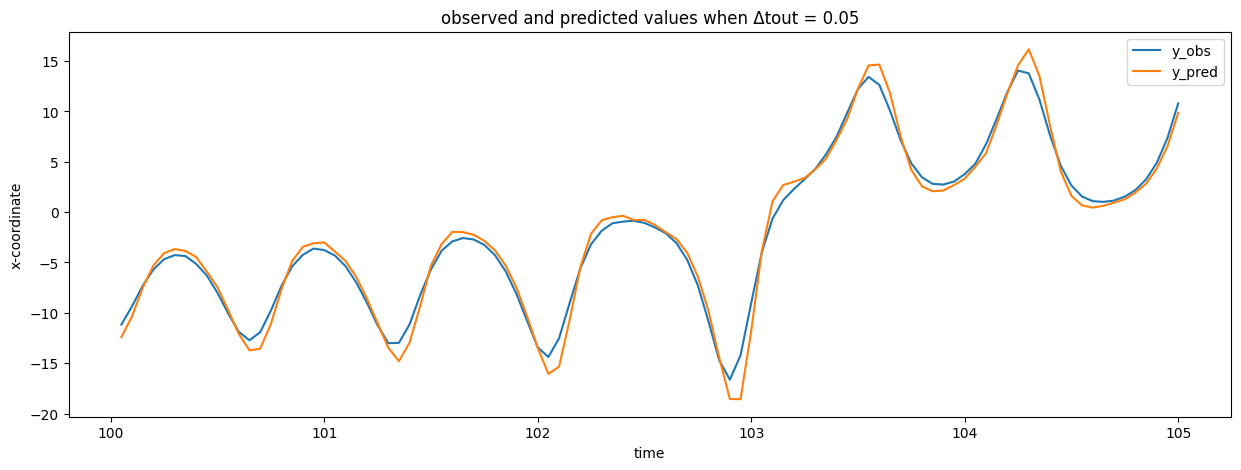

In [350]:
time = np.linspace(0.05, 200, 4000)
fig = plt.figure(figsize=(15,5))

plt.plot(time[2000:2100], y_obs[2000:2100], label="y_obs")
plt.plot(time[2000:2100], y_predict_05[2000:2100], label="y_pred")
plt.title("observed and predicted values when Δtout = 0.05")
plt.ylabel("x-coordinate")
plt.xlabel("time")
plt.legend()
plt.show()